In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List, Tuple
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda
from torchvision.transforms import Compose
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from models import SlimWide, SlimWideDeeper, torchvision_default_initialize_weights
from data_prep import stratified_split, DataSubSet, get_label

### Plotting functions

In [4]:
def plot_pred(img, label):
    plt.imshow(img)
    plt.title(label)
    
def plot_activations(activations, normalize=True):
    
    max_rows = len(activations)
    max_cols = max(len(a) for a in activations.values())
    fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,5))
    for row, (label, images) in enumerate(activations.items()):
        print(label)
        for col, image in enumerate(images):
            axes[row, col].axis("off")
            if not normalize:
                axes[row, col].imshow(image, aspect="auto", vmin=0, vmax=1)
            else:
                axes[row, col].imshow(image, aspect="auto")
            
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()    

def plot_matrix(ds, m, invert=False):
    activations = defaultdict(list)

    for img, cls in (ds[i] for i in range(len(ds))):
        label = get_label(ds, cls)
        x = img.unsqueeze(0).to(next(m.parameters()).device)
        y_mask = torch.sigmoid(m(x)).data.cpu().squeeze()
        if invert:
            y_mask = 1.0 - y_mask
        activations[label].append(y_mask)
        
    plot_activations(activations, normalize=False)

def plot_ds(ds):
    activations = defaultdict(list)

    for img, cls in (ds[i] for i in range(len(ds))):
        label = get_label(ds, cls)
        activations[label].append(torch.sigmoid(img).squeeze())
        max_rows = len(activations)
        
    plot_activations(activations, normalize=False)

### Data preparation

In [5]:
#We normalize to the mean dynamically
def normalize_dynamic(tensor_img):
    mean = torch.mean(tensor_img)
    return (tensor_img-mean)/0.1388

tf_eval = Compose([transforms.Grayscale(),
                   transforms.ToTensor(),
                   normalize_dynamic
                  ])

tf_train = Compose([transforms.Grayscale(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    normalize_dynamic
                   ])

#We split by stratified sampling
ds = ImageFolder('../photomask_trainingdata')
eval_idx, train_idx = stratified_split([x[1] for x in ds.samples])

ds_eval = DataSubSet(ds, eval_idx, transform=tf_eval)
ds_train = DataSubSet(ds, train_idx, transform=tf_train)

### We look at the logits of the initialized model

In [6]:
m = SlimWide()
torchvision_default_initialize_weights(m)

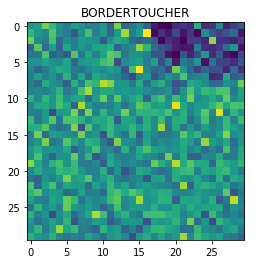

In [7]:
x, cls = ds_eval[2]
x = x.unsqueeze(0).to(next(m.parameters()).device)
label = get_label(ds, cls)

y_mask = torch.sigmoid(m(x)).data.cpu().squeeze(1)
plot_pred(y_mask[0].numpy(), label)

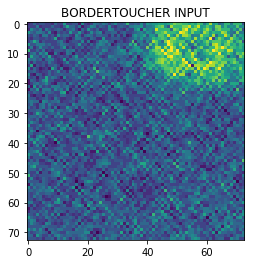

In [8]:
plot_pred(x.squeeze().data.cpu().numpy(), label + " INPUT")

In [9]:
scale_down = x.shape[-1] // y_mask.shape[-1]
print("SCALE DOWN of model is", scale_down)

SCALE DOWN of model is 2


### We describe our loss for weakly supervised segmentation

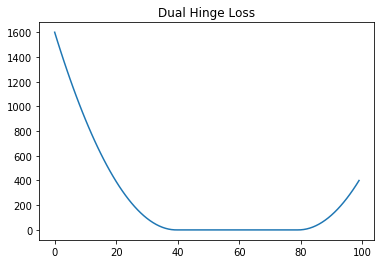

In [26]:
def loss_hinge(result_sum, min_sum:float = 2000, max_sum:float = 6000):
    loss = F.relu(result_sum - max_sum) + \
           F.relu(-result_sum + min_sum)
    return loss**2

losses = []
for s in torch.linspace(0, 100, 100):
    losses.append(loss_hinge(s, 40, 80))
plt.title("Dual Hinge Loss")
plt.plot(losses)

# TRAINING

In [27]:
from torch import optim
from torch.utils.data import DataLoader

def loss_hinge(result_sum, min_sum: float, max_sum: float):
    loss = F.relu(result_sum - max_sum) + \
           F.relu(-result_sum + min_sum)
    return loss

In [60]:
def run_epoch(ds, m, optimizer, epoch_nr=0, num_workers=0, scale_down=2,
              debug_print=True, debug_plot=True, train=True,
              TRUTH_BOUNDS={"NO FEATURE":       (0, 10),
                            "COMPLETE FEATURE": (2000, 30000),
                            "BORDERTOUCHER":    (1500, 4000)}):
    if train:
        m.train()
    else:
        m.eval()

    #Without special collate function, we need to take batches of on sample
    dl = DataLoader(ds, num_workers=num_workers)
    device = next(m.parameters()).device

    # How many pixels are active for each class
    sums = defaultdict(list)
    losses = []
    
    for b, (imgs, classes) in enumerate(dl):
        
        imgs = imgs.to(device)
        
        if train:
            optimizer.zero_grad()
            preds = m(imgs)
        else:
            with torch.no_grad():
                preds = m(imgs)

        preds = torch.sigmoid(preds)
        labels = [get_label(ds, k.item()) for k in classes]
        truths = [TRUTH_BOUNDS[l] for l in labels]
        
        """"
        #Instead of dual hinge loss, we can start with a lesser version (L1)
        target = torch.tensor([(lower + upper) * 0.5 for lower,upper in truths],
                              requires_grad=False, device=device)
        single_loss = F.smooth_l1_loss(torch.sum(preds.view(imgs.shape[0], -1), dim=1), 
                                       target, reduction="none")
        loss = single_loss.sum() / target.sum()

        for pred, label in zip(preds, labels):
            s = pred.sum()
            sums[label].append(s.item())

        """
        single_losses = []
        for pred, _cls in zip(preds, classes):
            s = pred.sum()

            label = get_label(ds, _cls.item())
            lower, upper = TRUTH_BOUNDS[label]
            lower = float(lower/(scale_down**2))
            upper = float(upper/(scale_down**2))
            l = loss_hinge(s, lower, upper)
            single_losses.append(l)
            sums[label].append(s.item())

        loss = sum(single_losses)
        """"""

        if train:
            loss.backward()
            optimizer.step()

        if debug_print:
            print(f"E[{epoch_nr}]-train {b}: {loss:.2f}, shapes: {[i.shape for i in imgs]}, labels: {labels}")

        losses.append(loss.item())

    if debug_plot:
        import matplotlib.pyplot as plt

        for label, v in sums.items():
            plt.plot(sorted(v), ".", label=label)
        plt.legend()
        plt.title("TRAIN" if train else "EVAL")

    return losses

In [62]:
#########################################
torchvision_default_initialize_weights(m)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

m.to(device)

#optimizer = torch.optim.SGD(m.parameters(), lr=1e-6, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5, eps=1e-2, weight_decay=5e-4)

epoch_nr = 0

In [63]:
while epoch_nr < 80:
    losses = run_epoch(ds_train, m, optimizer, epoch_nr=epoch_nr, train=True, scale_down=scale_down,
                       debug_print=False, debug_plot=False)
    print(f"E[{epoch_nr}] AVERAGE:", sum(losses)/len(losses))
    epoch_nr += 1

E[0] AVERAGE: 1214.2481663736064
E[1] AVERAGE: 961.1556135884831
E[2] AVERAGE: 705.449898366178
E[3] AVERAGE: 500.64112528254475
E[4] AVERAGE: 377.2260316998771
E[5] AVERAGE: 340.43487926011676
E[6] AVERAGE: 319.90945211689126
E[7] AVERAGE: 303.0502494211947
E[8] AVERAGE: 290.49255936869076
E[9] AVERAGE: 279.7957400204091
E[10] AVERAGE: 269.3767665905899
E[11] AVERAGE: 260.37424323264133
E[12] AVERAGE: 252.3835685815704
E[13] AVERAGE: 244.7639859660288
E[14] AVERAGE: 237.91578640026992
E[15] AVERAGE: 231.17935540702905
E[16] AVERAGE: 225.18496652667443
E[17] AVERAGE: 219.70617932951853
E[18] AVERAGE: 214.12209174338352
E[19] AVERAGE: 209.73635641376623
E[20] AVERAGE: 205.19635969869208
E[21] AVERAGE: 200.81818278451985
E[22] AVERAGE: 198.92479800106435
E[23] AVERAGE: 197.89808089009833
E[24] AVERAGE: 196.6960529798872
E[25] AVERAGE: 194.49744115250834
E[26] AVERAGE: 192.92596589849236
E[27] AVERAGE: 191.9086569453893
E[28] AVERAGE: 191.1228215935525
E[29] AVERAGE: 189.68921618515185
E[

## Qualitative Results

BORDERTOUCHER
COMPLETE FEATURE
NO FEATURE


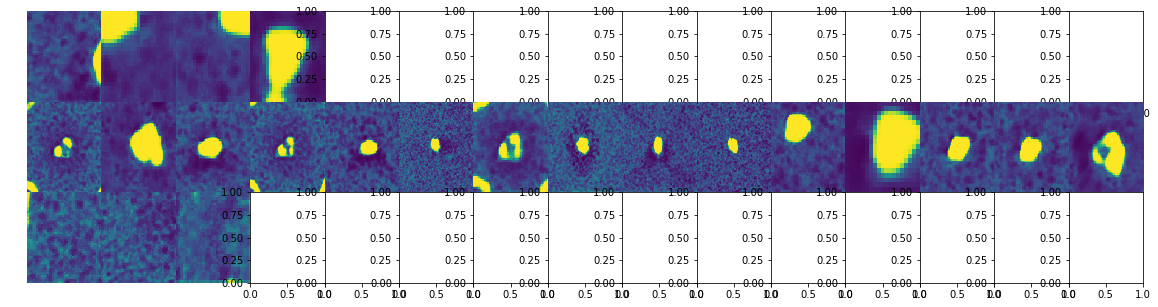

In [64]:
plot_matrix(ds_eval, m)

BORDERTOUCHER
COMPLETE FEATURE
NO FEATURE


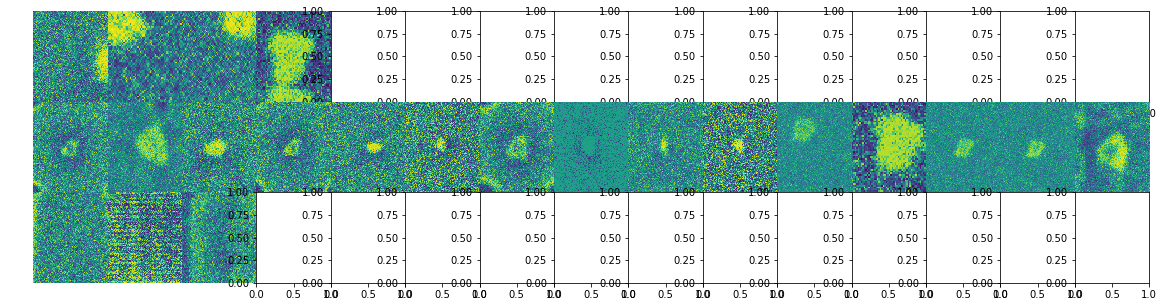

In [66]:
plot_ds(ds_eval)

## Feature activations per category

E[80]-train 0: 0.00, shapes: [torch.Size([1, 108, 108])], labels: ['BORDERTOUCHER']
E[80]-train 1: 241.37, shapes: [torch.Size([1, 59, 59])], labels: ['BORDERTOUCHER']
E[80]-train 2: 187.42, shapes: [torch.Size([1, 73, 73])], labels: ['BORDERTOUCHER']
E[80]-train 3: 82.33, shapes: [torch.Size([1, 61, 61])], labels: ['BORDERTOUCHER']
E[80]-train 4: 0.00, shapes: [torch.Size([1, 178, 178])], labels: ['COMPLETE FEATURE']
E[80]-train 5: 0.00, shapes: [torch.Size([1, 131, 131])], labels: ['COMPLETE FEATURE']
E[80]-train 6: 0.00, shapes: [torch.Size([1, 140, 140])], labels: ['COMPLETE FEATURE']
E[80]-train 7: 0.00, shapes: [torch.Size([1, 178, 178])], labels: ['COMPLETE FEATURE']
E[80]-train 8: 0.00, shapes: [torch.Size([1, 179, 179])], labels: ['COMPLETE FEATURE']
E[80]-train 9: 0.00, shapes: [torch.Size([1, 365, 365])], labels: ['COMPLETE FEATURE']
E[80]-train 10: 0.00, shapes: [torch.Size([1, 126, 126])], labels: ['COMPLETE FEATURE']
E[80]-train 11: 0.00, shapes: [torch.Size([1, 260, 260]

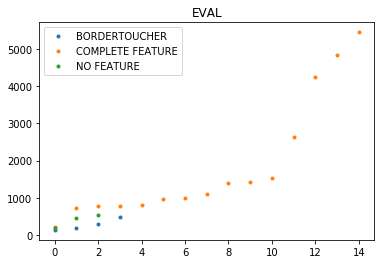

In [67]:
eval_losses = run_epoch(ds_eval, m, optimizer, epoch_nr=epoch_nr, train=False, 
                        debug_print=True, scale_down=scale_down)
print(f"E[{epoch_nr}] AVERAGE:", sum(eval_losses)/len(eval_losses))

E[80] AVERAGE: 143.1888858066516


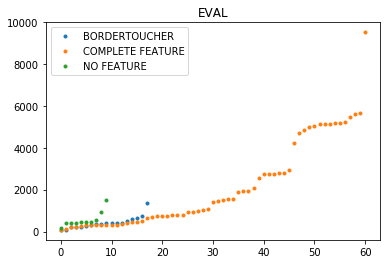

In [68]:
losses = run_epoch(ds_train, m, optimizer, epoch_nr=epoch_nr, train=False, scale_down=scale_down,
                   debug_print=False, debug_plot=True)
print(f"E[{epoch_nr}] AVERAGE:", sum(losses)/len(losses))
epoch_nr += 1

In [70]:
#Optionally save
with open("SlimWide_weakly_3.pth", "wb") as f:
    torch.save(m.state_dict(), f)

In [32]:
m2 = SlimWide()
m2.load_state_dict(torch.load("SlimWide_weakly_3.pth"))